In [ ]:
!pip install flaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 206 kB 29.9 MB/s 
     |████████████████████████████████| 2.0 MB 29.7 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas  as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Carseats.csv')
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 37.5+ KB


In [ ]:
X = df.drop('Sales', axis = 1)
y = df.Sales

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 33)

In [ ]:
X_train_numerics = X_train.select_dtypes(exclude = 'object')
ss = StandardScaler()
X_train_numeric = pd.DataFrame(ss.fit_transform(X_train_numerics))
X_train_numeric.set_index(X_train.index, inplace = True)
X_train_numeric.columns = X_train_numerics.columns
X_train_numeric.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education
11,-0.519682,0.865873,-0.413823,1.619408,-0.952591,-0.180258,-0.386274
214,-0.648968,1.614819,-0.562949,-1.456166,-0.391427,1.260019,1.504576
361,0.385317,-1.594949,0.480930,-0.543633,-0.520926,0.195466,0.370066
98,-0.196468,0.259584,2.568687,0.801508,0.471902,-1.056948,0.748236
358,-0.131825,0.937202,0.480930,-1.300697,0.083404,1.009536,-1.142613


In [ ]:
non_outliers = (np.abs(stats.zscore(X_train_numeric)) < 2.5).all(axis = 1)
X_train_numeric = X_train_numeric[non_outliers]
y_train = y_train[non_outliers]
X_train_cat = X_train.select_dtypes(include = 'object')

from sklearn.preprocessing import LabelBinarizer
urban_bin = LabelBinarizer()
us_bin = LabelBinarizer()
X_train_cat.Urban = urban_bin.fit_transform(X_train_cat.Urban)
X_train_cat.US = us_bin.fit_transform(X_train_cat.US)

In [ ]:
X_cat_prepped = X_train_cat.merge(pd.get_dummies(X_train_cat.ShelveLoc, drop_first=True), left_index=True, right_index=True)
X_cat_prepped.drop('ShelveLoc', axis = 1, inplace=True)

In [ ]:
X_train_prep = pd.merge(X_cat_prepped, X_train_numeric, left_index = True, right_index = True)
X_train_prep.shape

(271, 11)

In [ ]:
X_test_numerics = X_test.select_dtypes(exclude = 'object')
X_test_numeric = pd.DataFrame(ss.transform(X_test_numerics))
X_test_numeric.set_index(X_test.index, inplace = True)
X_test_numeric.columns = X_test_numerics.columns
X_test_numeric.head()
X_test_cat = X_test.select_dtypes(include = 'object')
X_test_cat.Urban = urban_bin.transform(X_test_cat.Urban)
X_test_cat.US = us_bin.transform(X_test_cat.US)

X_cat_prepped1 = X_test_cat.merge(pd.get_dummies(X_test_cat.ShelveLoc, drop_first=True), left_index=True, right_index=True)
X_cat_prepped1.drop('ShelveLoc', axis = 1, inplace=True)

X_test_prep = pd.merge(X_cat_prepped1, X_test_numeric, left_index = True, right_index = True)
X_test_prep.head()

,Urban,US,Good,Medium,CompPrice,Income,Advertising,Population,Price,Age,Education
239,1,1,0,0,-0.131825,1.258178,-1.010325,-0.773456,0.083404,0.571191,0.748236
322,1,1,1,0,0.967103,-0.703347,0.480930,0.247229,0.989899,0.445949,0.370066
375,1,0,0,1,0.449960,-0.846003,-0.413823,-0.388164,0.342402,1.260019,-1.142613
90,0,0,0,1,-0.648968,-1.701942,-1.010325,1.538294,-0.564093,0.696432,-1.142613
70,1,1,1,0,-2.329681,0.402240,1.226557,-0.178620,-0.736759,1.322639,-0.764443


In [ ]:
y_train

11     11.96
214     4.83
361     8.68
358     4.17
54      4.90
       ...  
146     3.90
66      8.85
216     5.73
391     6.10
20      6.41
Name: Sales, Length: 271, dtype: float64

In [ ]:
from flaml import AutoML
automl = AutoML()
automl.fit(X_train_prep, y_train, task="regression")

[flaml.automl: 10-05 19:05:34] {2600} INFO - task = regression
INFO:flaml.automl:task = regression
[flaml.automl: 10-05 19:05:34] {2602} INFO - Data split method: uniform
INFO:flaml.automl:Data split method: uniform
[flaml.automl: 10-05 19:05:34] {2605} INFO - Evaluation method: holdout
INFO:flaml.automl:Evaluation method: holdout
[flaml.automl: 10-05 19:05:34] {2727} INFO - Minimizing error metric: 1-r2
INFO:flaml.automl:Minimizing error metric: 1-r2
[flaml.automl: 10-05 19:05:34] {2778} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.
INFO:flaml.default.suggest:metafeature distance: 0.4218594382600944
INFO:flaml.default.suggest:metafeature distance: 0.1982436241729096
INFO:flaml.default.suggest:metafeature distance: 0.41544258228503117
INFO:flaml.default.suggest:metafeature distance: 0.15380895552915208
INFO:flaml.default.sugg

In [ ]:
automl

AutoML(append_log=False, auto_augment=True, custom_hp={},
       cv_score_agg_func=None, early_stop=False, ensemble=False,
       estimator_list='auto', eval_method='auto', fit_kwargs_by_estimator={},
       hpo_method='auto', keep_search_state=False, learner_selector='sample',
       log_file_name='', log_training_metric=False, log_type='better',
       max_iter=None, mem_thres=4294967296, metric='auto',
       metric_constraints=[], min_sample_size=10000, model_history=False,
       n_concurrent_trials=1, n_jobs=-1, n_splits=5, pred_time_limit=inf,
       preserve_checkpoint=True, retrain_full=True, sample=True,
       skip_transform=False, split_ratio=0.1, ...)

In [ ]:
from sklearn.metrics import mean_squared_error

pred = automl.predict(X_test_prep)
mse = mean_squared_error(y_test, pred)
mse

3.028736303878268

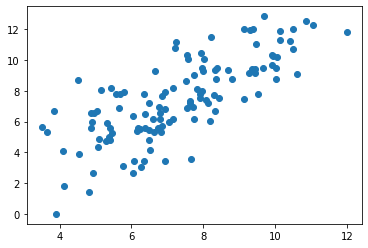

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(pred, y_test)

In [ ]:
print(automl.model.estimator)

XGBRegressor(colsample_bylevel=1.0, colsample_bytree=1.0,
             learning_rate=0.29999999999999993, max_depth=6,
             min_child_weight=0.9999999999999993, n_estimators=10, n_jobs=-1,
             reg_alpha=0.0009765625, reg_lambda=1.0, subsample=1.0,
             use_label_encoder=False, verbosity=0)
